In [203]:
import json
import requests

import numpy as np

### define function for RPC request

In [204]:
def doRequest(device, req):
#    req['subsystem'] = device['dev']
    print('http://' + device['ip'] + ':' + device['port'] +
          '/flugegeheimen')
    print(json.dumps(req))
    r = requests.post('http://' + device['ip'] + ':' + device['port'] +
                      '/flugegeheimen', data=json.dumps(req))
    #print(r.json())
    return r.json()

define device

In [205]:
device = {'ip': '192.168.10.21', 'port': '8080'}

get Info from device

In [250]:
req = {"reqtype": "drsInfo", "subsystem": "drs"}
ret = doRequest(device, req)
ret

http://192.168.10.21:8080/flugegeheimen
{"reqtype": "drsInfo", "subsystem": "drs"}


{'BurstLength': 500,
 'CallerState': 'STATE_StandBy',
 'DRS_Chan': 0,
 'DRS_Counter': 0,
 'DRS_Cycle': 0,
 'DRS_Finished': 0,
 'DRS_Index': 0,
 'DRS_Point': 0,
 'HpsTrigger': 0,
 'Latch': False,
 'LatchCounter': 0,
 'LatchReset': False,
 'state': 'STATE_StandBy',
 'status': 'success'}

In [236]:
print("dev #",device['ip'])
print("state:",ret['state'])

dev # 192.168.10.21
state: STATE_BurstTrigWait


# Check HV parameters

# Apply calibration

# Read pages

### Set trigger parameters

In [63]:
# {"reqtype":"triggerConfig","invertedFront":false,"type":"ch1","delay":0,"value":0.05,"subsystem":"drs"}:
# {"reqtype":"awaitTrigger","burstLength":2,"subsystem":"drs"}:
# {"reqtype":"drsInfo","subsystem":"drs"}: 
# {"reqtype":"getPagesReady","subsystem":"drs"}:
#{"reqtype":"regionGetData","from":0,"pages":2,"subsystem":"drs"}: 

In [211]:
req = {"reqtype": "triggerConfig", "subsystem": "drs","invertedFront": False,"type":"ch1","delay":0,"value":0.05,}
ret = doRequest(device, req)
ret

http://192.168.10.21:8080/flugegeheimen
{"reqtype": "triggerConfig", "subsystem": "drs", "invertedFront": false, "type": "ch1", "delay": 0, "value": 0.05}


{'status': 'success'}

### Read pages

In [212]:
N_pages_set = 6 # number of pages to be recorded

In [193]:
req = {"reqtype":"awaitTrigger","burstLength":N_pages_set,"subsystem":"drs"}
ret = doRequest(device, req)
print(ret)
print('___________________')
if ret['status']=='success':
    print('Number of pages to be registered: ', N_pages_set)


http://192.168.10.21:8080/flugegeheimen
{"reqtype": "awaitTrigger", "burstLength": 6, "subsystem": "drs"}
{'status': 'success'}
___________________
Number of pages to be registered:  6


### Check number of pages 

In [194]:
req = {"reqtype":"getPagesReady","subsystem":"drs"}
ret = doRequest(device, req)
print(ret)
N_pages_get = ret['pagesReady']
print('________________________________________')
print('Number of registered pages: ',N_pages_get)

http://192.168.10.21:8080/flugegeheimen
{"reqtype": "getPagesReady", "subsystem": "drs"}
{'pagesReady': 0, 'status': 'success', 'total': 6}
________________________________________
Number of registered pages:  0


### Download data

In [251]:
N_pages_get = 50
req = {"reqtype":"regionGetData","from":0,"pages":N_pages_get,"subsystem":"drs"} 
ret_data = doRequest(device, req)

http://192.168.10.21:8080/flugegeheimen
{"reqtype": "regionGetData", "from": 0, "pages": 50, "subsystem": "drs"}


In [252]:
ret_data.keys()

dict_keys(['data', 'readPagesCount', 'startPageNo', 'status', 'stops', 'stopsSelection', 'timestamps', 'timestampsSelection'])

In [240]:
print('________________')
print('Number of downloaded pages:',ret_data['readPagesCount'])
#ret_data['data']
#ret_data['stops']
#ret_data['stopsSelection']
#ret_data['timestamps']
times = np.array(ret_data['timestampsSelection'])
times = times-times[0]
print('________________')
print('relative timestamps in ms')
times = np.round(times*2E-8*1000) #relative timestamps in ms
print(times)

________________
Number of downloaded pages: 20
________________
relative timestamps in ms
[  0.   9.  18.  27.  36.  45.  55.  64.  73.  82.  91. 100. 109. 118.
 127. 136. 145. 155. 164. 173.]


In [241]:
#ret_data['data']

In [242]:
data = np.array(ret_data['data'])
np.shape(data)

(8, 20480)

### plot data

In [243]:
import matplotlib.pyplot as plt

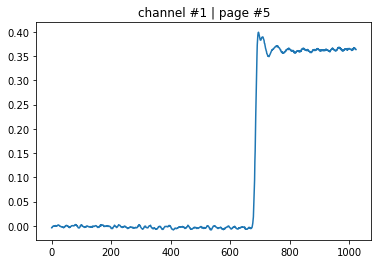

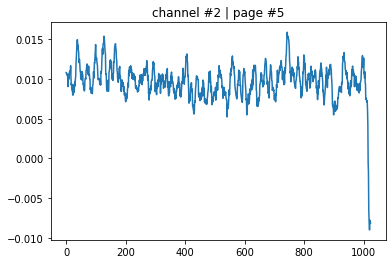

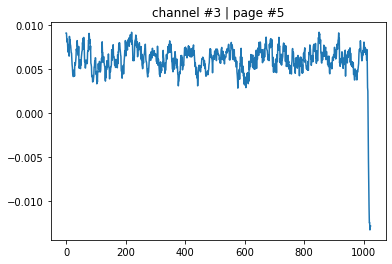

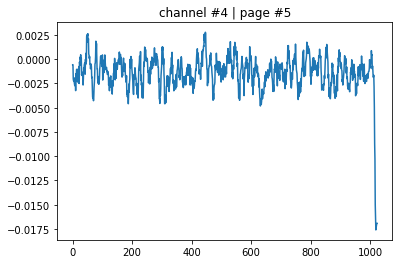

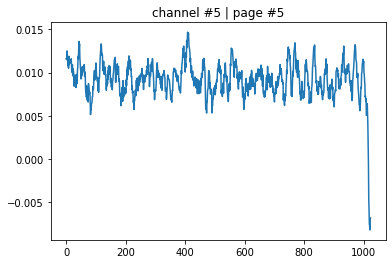

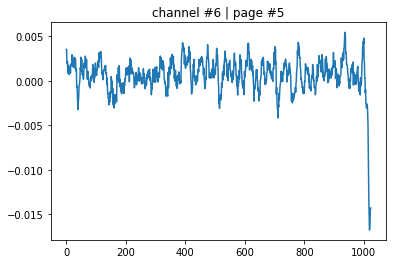

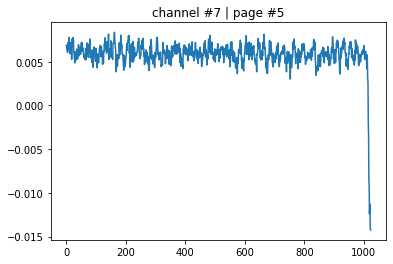

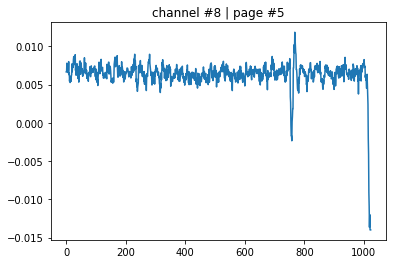

In [226]:
N_page_to_plot = 5
for i in range(8):
    plt.figure()
    plt.title('channel #'+str(i+1)+' | page #'+str(N_page_to_plot))
    plt.plot(data[i,N_page_to_plot*1024:(N_page_to_plot+1)*1024])

### Read All data

In [275]:
shot_N = 39491
N_pages_total = 292


for N_pages_get in range(0, N_pages_total + 50, 50):
    if  0 < N_pages_total - N_pages_get < 50:
        req = {"reqtype":"regionGetData","from":N_pages_get,"pages": N_pages_total - N_pages_get,"subsystem":"drs"} 
    elif N_pages_total - N_pages_get > 0: 
        req = {"reqtype":"regionGetData","from":N_pages_get,"pages":50,"subsystem":"drs"} 
    ret_data = doRequest(device, req)
    print('________________')
    print(ret_data.keys())
    print('Number of downloaded pages:',ret_data['readPagesCount'])
    #ret_data['data']
    #ret_data['stops']
    #ret_data['stopsSelection']
    #ret_data['timestamps']
    times = np.array(ret_data['timestampsSelection'])
    times = times-times[0]
    print('________________')
    print('relative timestamps in ms')
    times = np.round(times*2E-8*1000) #relative timestamps in ms
    print(times)
    
    if N_pages_total - N_pages_get > 0: 
        with open(str(shot_N) + '_' + str(N_pages_get) + '_to_' + str(N_pages_get + 50) +'.json','w') as fp:
            json.dump(ret_data, fp)
    elif 50 > N_pages_total - N_pages_get > 0:
        with open(str(shot_N) + '_' + str(N_pages_get) + '_to_' + str(N_pages_total - N_pages_get) +'.json','w') as fp:
            json.dump(ret_data, fp)

    #json.dump('ss.json',ret_data)


http://192.168.10.21:8080/flugegeheimen
{"reqtype": "regionGetData", "from": 0, "pages": 50, "subsystem": "drs"}
________________
dict_keys(['data', 'readPagesCount', 'startPageNo', 'status', 'stops', 'stopsSelection', 'timestamps', 'timestampsSelection'])
Number of downloaded pages: 50
________________
relative timestamps in ms
[  0.   9.  18.  27.  36.  45.  55.  64.  73.  82.  91. 100. 109. 118.
 127. 136. 145. 155. 164. 173. 182. 191. 200. 209. 218. 227. 236. 245.
 254. 264. 273. 282. 291. 300. 309. 318. 327. 336. 345. 354. 364. 373.
 382. 391. 400. 409. 418. 427. 436. 445.]
http://192.168.10.21:8080/flugegeheimen
{"reqtype": "regionGetData", "from": 50, "pages": 50, "subsystem": "drs"}
________________
dict_keys(['data', 'readPagesCount', 'startPageNo', 'status', 'stops', 'stopsSelection', 'timestamps', 'timestampsSelection'])
Number of downloaded pages: 50
________________
relative timestamps in ms
[  0.   9.  18.  27.  36.  45.  55.  64.  73.  82.  91. 100. 109. 118.
 127. 136. 

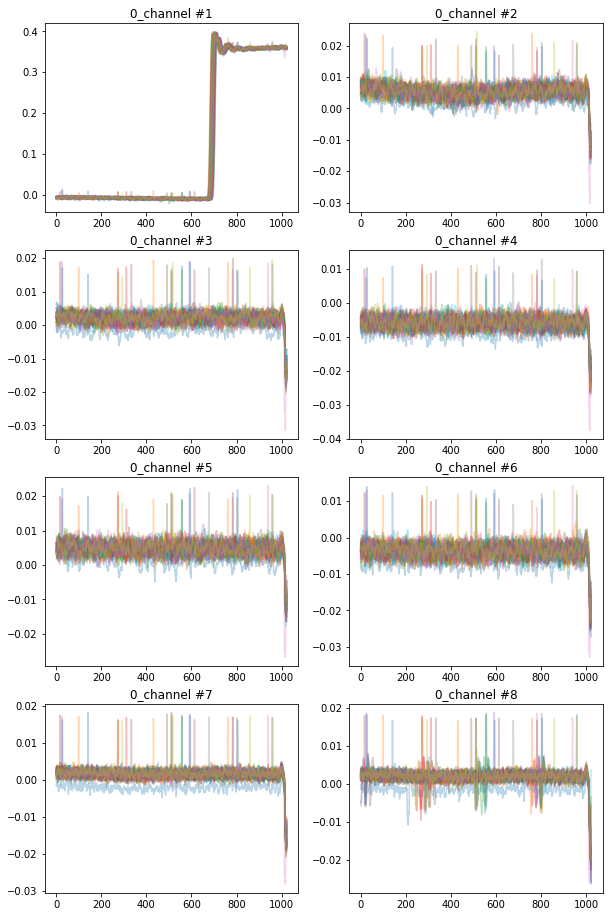

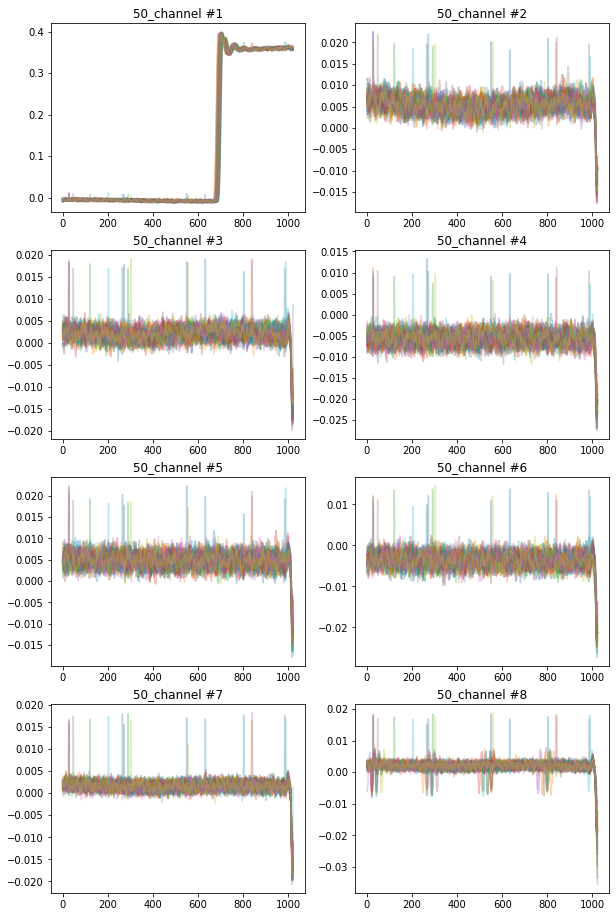

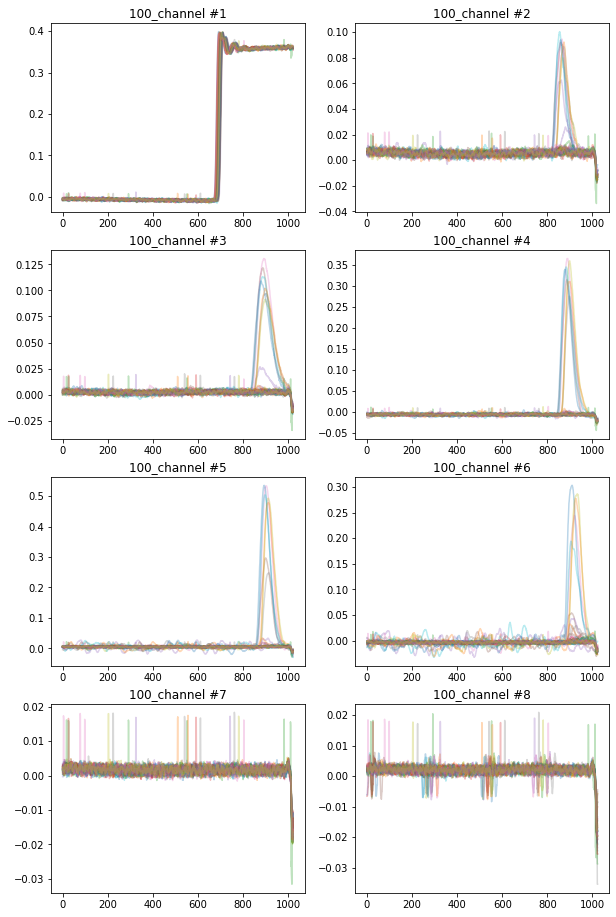

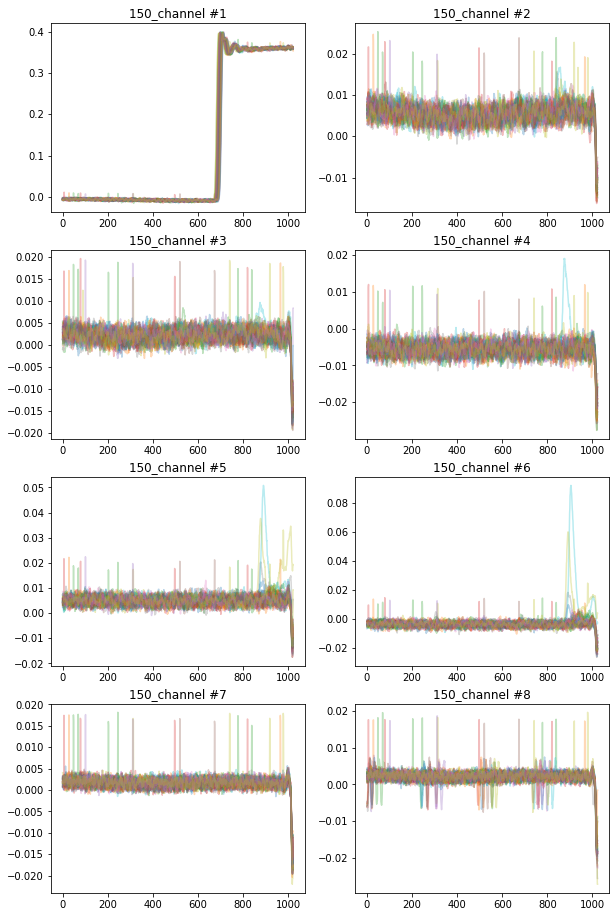

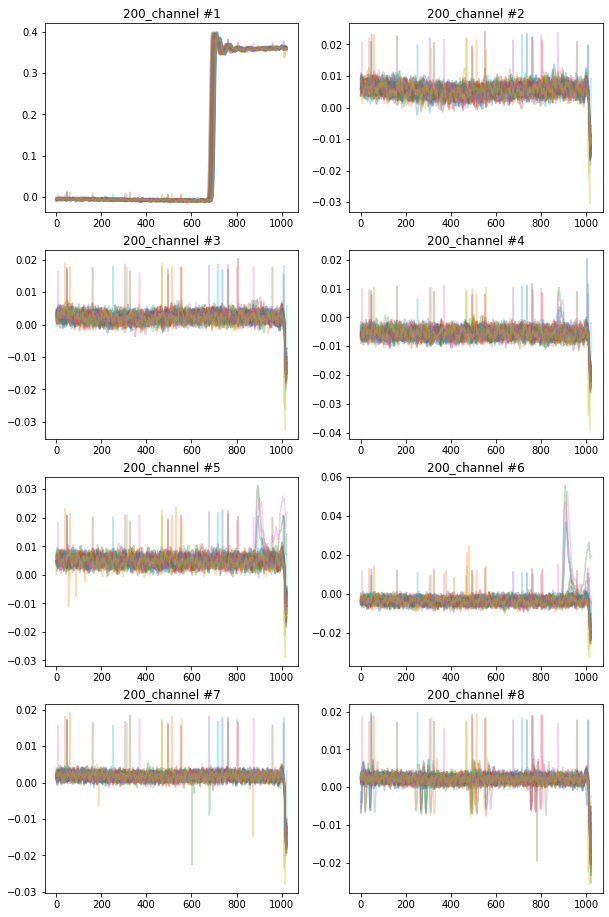

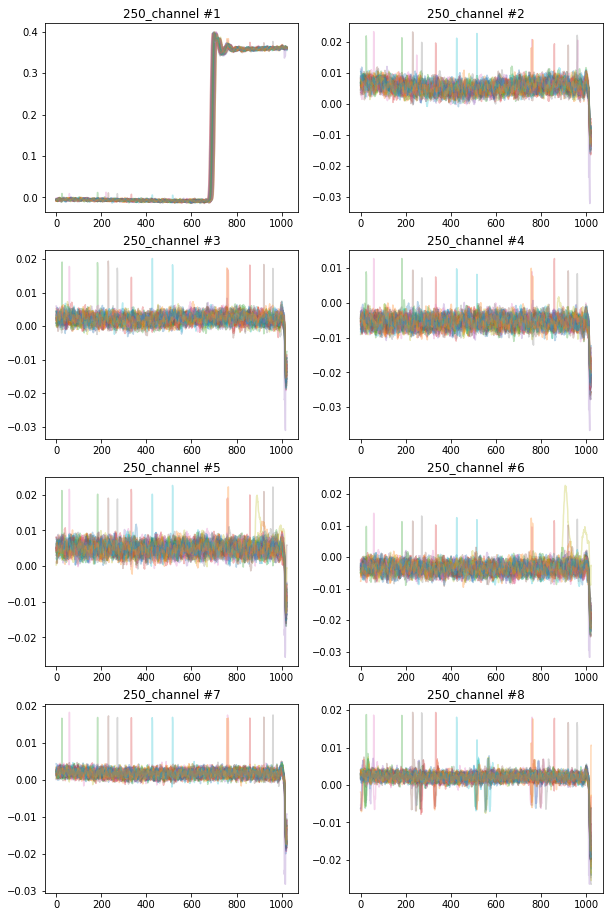

In [281]:
for n_file in range(0, N_pages_total, 50):
    with open(str(shot_N) + '_' + str(n_file) + '_to_' + str(n_file + 50) +'.json', 'r') as f:
        read_data = json.load(f)

    plt.figure(figsize=(10, 16))
    p = 1
    for i in range(8):
        plt.subplot(4, 2, p)
        plt.title(str(n_file) + '_channel #'+str(i+1))
        for page in range(49):
            plt.plot(read_data['data'][i][page*1024:(page+1)*1024], alpha=0.3)
        p += 1